## Apply Dirichlet Thompson Sampling on the Movielens Dataset
The goal is to maximize the number of relevant movie suggestions using `IndependentBandits` and `DirichletThompsonSampling`.
A rating of 4 and above is considered as positive feedback for the recommendation.

In [36]:
import numpy as np
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
from collections import Counter
from urllib.request import urlopen

from mab_ranking.bandits.rank_bandits import IndependentBandits
from mab_ranking.bandits.bandits import BetaThompsonSampling, DirichletThompsonSampling


In [2]:
# Helper functions


def get_movielens_data(url):
    """
    Get the movielens data
    :param url: [str], url name
    """
    data = []
    resp = urlopen(url)
    zpfile = ZipFile(BytesIO(resp.read()))
    for line in zpfile.open('ml-100k/u1.base').read().splitlines():
        data.append(
            [int(float(x)) for x in line.decode('utf-8').split('\t')])

    return np.asarray(data)


def filter_data(data):
    """
    Filters the data by keeping rating greater or equal than 4.
    Removes events that contain movies that don't belong in the top 100
    
    :param data: list[int], events data
    """
    data_pos_rating = np.asarray([x for x in data if x[2] >= 4])
    movies = [x[1] for x in data_pos_rating]
    freq = Counter(movies)
    keep_movies = [x[0] for x in freq.most_common(100)]

    filtered_data = []
    for d in data_pos_rating:
        if d[1] in keep_movies:
            filtered_data.append(d)

    return np.asarray(filtered_data)


def index_data(data):
    """
    Indexed users and movies
    
    :param data: list[int], events data
    """
    user_indexer = {v: i for i, v in enumerate(set([d[0] for d in data]))}
    movie_indexer = {v: i for i, v in enumerate(set([d[1] for d in data]))}
    indexed_data = []
    for d in data:
        d[0] = user_indexer[d[0]]
        d[1] = movie_indexer[d[1]]
        indexed_data.append(d)
    return np.asarray(indexed_data), user_indexer, movie_indexer


def running_mean(x, n):
    """
    Calculates the running mean
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)


def plot_ctr(num_iterations, ctr):
    """
    Plots the CTR over time
    
    :param num_iterations: [int], number or iterations
    :param ctr: list[float], ctrs over each time step
    """
    plt.plot(range(1, num_iterations + 1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    return plt


In [3]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'

# get the movielens data
data = get_movielens_data(url)

# filter the data
filtered_data = filter_data(data)

# index the data
indexed_data, user_indexer, movie_indexer = index_data(filtered_data)

# sort the data by timestamp
indexed_data_sorted = sorted(indexed_data, key=lambda x: x[3])


In [34]:
def experiment(indexed_data_sorted, independent_bandits):
    # instantiate the dictionary that would hold all the past actions of each user
    # initial state is 0
    actions_dict = {}
    for i in indexed_data_sorted:
        if i[0] not in actions_dict:
            actions_dict[i[0]] = [0]

    sum_binary = 0.0
    ctr_list = []
    k = 100
    i = 1
    for d in tqdm(indexed_data_sorted):
        ground_truth = [d[1]]

        selected_items = independent_bandits.choose(context={'previous_action': actions_dict[d[0]][-1]})
        actions_dict[d[0]] += ground_truth
        hit_rate = len(set(ground_truth).intersection(set(selected_items))) / len(set(ground_truth))

        feedback_list = [1.0 if _item in ground_truth else 0.0 for _item in selected_items]
        independent_bandits.update(selected_items, feedback_list)

        binary_relevancy = 1.0 if hit_rate > 0 else 0.0
        sum_binary += binary_relevancy
        ctr_list.append(sum_binary / i)
        i += 1

    ctr_avg = running_mean(ctr_list, k)

    return ctr_avg



## Empirical Results for Dirichlet-based Approach

In [29]:
num_experiments = 30
list_of_averages = []


for _ in range(num_experiments):
    # instantiate the bandit
    independent_bandits = IndependentBandits(
        num_arms=len(movie_indexer),
        num_ranks=10,  # Recommend the best 10 movies
        bandit_class=DirichletThompsonSampling
    )
    
    ctr_avg = experiment(indexed_data_sorted, independent_bandits)
    list_of_averages.append(ctr_avg)

100%|██████████| 16635/16635 [02:02<00:00, 135.65it/s]


In [30]:
import numpy as np

list_of_averages_arr = np.array(list_of_averages)

In [31]:
list_of_averages[0]

array([0.06323972, 0.06383378, 0.06442202, ..., 0.11458627, 0.11458419,
       0.11458211])

In [32]:
result = np.mean(list_of_averages_arr, axis=0).tolist()

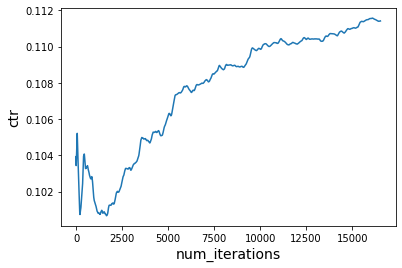

In [33]:
plot_ctr(len(result), result).show()

## Empirical Results for IBA with BetaTS

In [37]:
num_experiments = 30
list_of_averages = []


for _ in range(num_experiments):
    # instantiate the bandit
    independent_bandits = IndependentBandits(
        num_arms=len(movie_indexer),
        num_ranks=10,  # Recommend the best 10 movies
        bandit_class=BetaThompsonSampling
    )
    
    ctr_avg = experiment(indexed_data_sorted, independent_bandits)
    list_of_averages.append(ctr_avg)

100%|██████████| 16635/16635 [00:37<00:00, 442.73it/s]


In [38]:
list_of_averages_betats_arr = np.array(list_of_averages)

In [39]:
result_betats = np.mean(list_of_averages_betats_arr, axis=0).tolist()

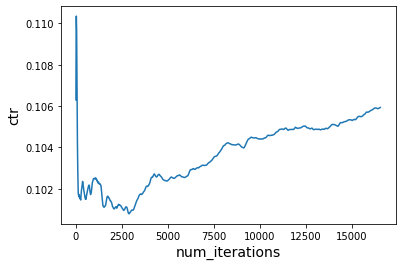

In [40]:
plot_ctr(len(result_betats), result_betats).show()